In [162]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [163]:
path2target = '/Users/y1u0d2/desktop/Lab/result/deepmd/Si/15'
e_test_files = glob(f'{path2target}/test_*.e.out')
e_train_files = glob(f'{path2target}/train_*.e.out')
f_test_files = glob(f'{path2target}/test_*.f.out')
f_train_files = glob(f'{path2target}/train_*.f.out')

print(len(e_test_files), len(e_train_files), len(f_train_files), len(f_test_files))

6 6 6 6


In [164]:
def get_energy_df(e_files):
    all_e_result = []
    for e_file in e_files:
        n_atom = int(e_file.split('/')[-1].split('.')[0].split('_')[-1])
        e_array = np.loadtxt(e_file, dtype=float, skiprows=1)
        all_e_result.append(np.hstack([e_array, np.array([[n_atom] for i in range(e_array.shape[0])])]))

    all_e_result = np.vstack(all_e_result)
    all_e_result_df = pd.DataFrame(data=all_e_result, columns=['obs_e', 'pred_e', 'n_atoms'])
    all_e_result_df['obs_e_atom'] = all_e_result_df['obs_e'] / all_e_result_df['n_atoms']
    all_e_result_df['pred_e_atom'] = all_e_result_df['pred_e'] / all_e_result_df['n_atoms']
    return all_e_result_df

In [165]:
all_train_e_result = get_energy_df(e_train_files)
all_test_e_result = get_energy_df(e_test_files)

print(f'train shape: {all_train_e_result.shape}')
print(f'test shape: {all_test_e_result.shape}')

train shape: (43658, 5)
test shape: (10918, 5)


In [166]:
def plot_obs_pred(obs, pred, title, unit):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    max_val = max(obs.max(), pred.max())
    min_val = min(obs.min(), pred.min())
    linspace = np.linspace(min_val, max_val, 10)

    ax.scatter(obs, pred, alpha=0.5)
    ax.plot(linspace, linspace)
    ax.set_title(title)
    ax.set_xlabel(f'DFT ({unit})')
    ax.set_ylabel(f'Predicted ({unit})')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    fig.show()

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_44982/2216864866.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


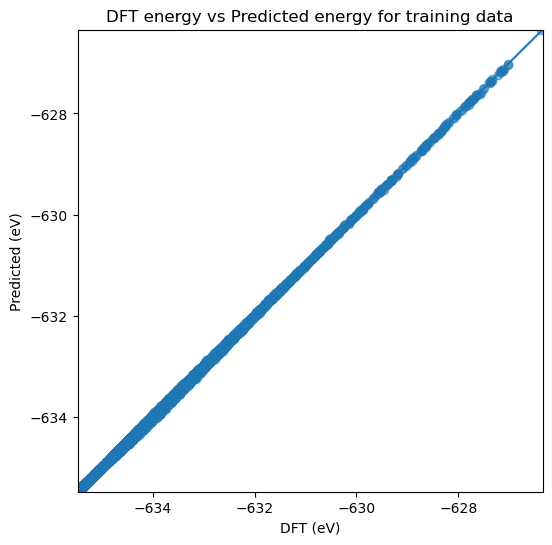

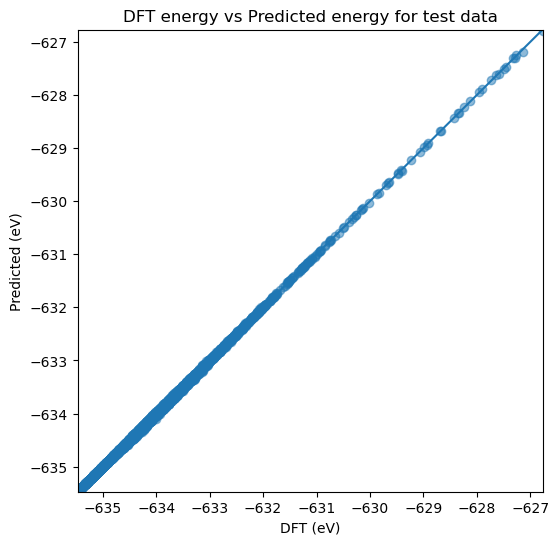

In [167]:
plot_obs_pred(
    obs=all_train_e_result['obs_e_atom'],
    pred=all_train_e_result['pred_e_atom'],
    title='DFT energy vs Predicted energy for training data',
    unit='eV'
    )

plot_obs_pred(
    obs=all_test_e_result['obs_e_atom'],
    pred=all_test_e_result['pred_e_atom'],
    title='DFT energy vs Predicted energy for test data',
    unit='eV'
    )

In [168]:
all_train_f_result = np.vstack([np.loadtxt(f_file, dtype=float, skiprows=1) for f_file in f_train_files])
all_test_f_result = np.vstack([np.loadtxt(f_file, dtype=float, skiprows=1) for f_file in f_test_files])

In [169]:
all_train_f_result.shape, all_test_f_result.shape

((673056, 6), (168360, 6))

In [170]:
columns = ['obs_fx', 'obs_fy', 'obs_fz', 'pred_fx', 'pred_fy', 'pred_fz']
all_train_f_result_df = pd.DataFrame(data=all_train_f_result, columns=columns)
all_test_f_result_df = pd.DataFrame(data=all_test_f_result, columns=columns)

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_44982/2216864866.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_44982/2216864866.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


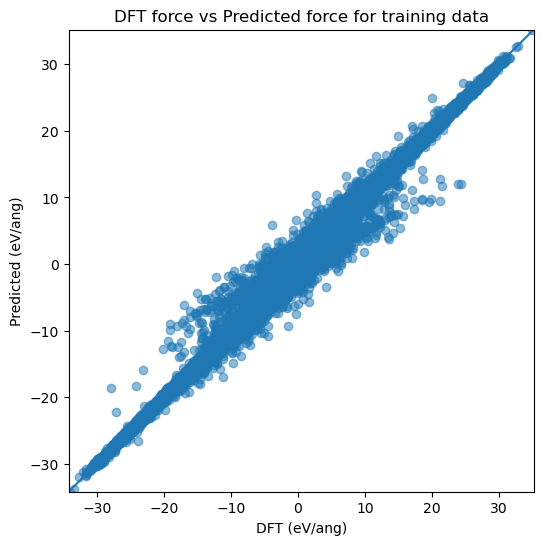

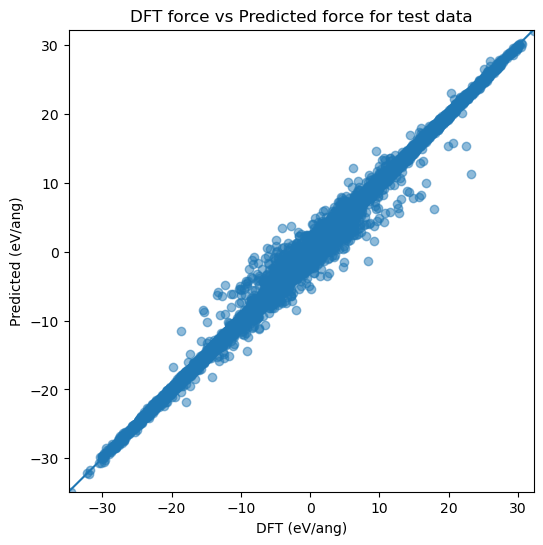

In [171]:
plot_obs_pred(
    all_train_f_result_df[[col for col in columns if 'obs' in col]].values.ravel(),
    all_train_f_result_df[[col for col in columns if 'pred' in col]].values.ravel(),
    title='DFT force vs Predicted force for training data',
    unit='eV/ang'
)

plot_obs_pred(
    all_test_f_result_df[[col for col in columns if 'obs' in col]].values.ravel(),
    all_test_f_result_df[[col for col in columns if 'pred' in col]].values.ravel(),
    title='DFT force vs Predicted force for test data',
    unit='eV/ang'
)

In [172]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calc_all_metrics(obs, pred, unit):
    print(f'shape of obs:{obs.shape}, pred:{pred.shape}')
    print(f'MAE: {mean_absolute_error(obs, pred)} [{unit}]')
    print(f'RMSE: {np.square(mean_squared_error(obs, pred))} [{unit}]')
    print(f'R2: {r2_score(obs, pred)}')

In [173]:
# For energy
print('Energy for training data')
calc_all_metrics(
    obs=all_train_e_result['obs_e'],
    pred=all_train_e_result['pred_e'],
    unit='eV'
)

print('-'*30)
print('Energy for test data')
calc_all_metrics(
    obs=all_test_e_result['obs_e'],
    pred=all_test_e_result['pred_e'],
    unit='eV'
)

Energy for training data
shape of obs:(43658,), pred:(43658,)
MAE: 0.10398644118605234 [eV]
RMSE: 0.0005693957718519688 [eV]
R2: 0.9999999996686945
------------------------------
Energy for test data
shape of obs:(10918,), pred:(10918,)
MAE: 0.1033424944905041 [eV]
RMSE: 0.000561545247907107 [eV]
R2: 0.9999999996711427


In [174]:
# For force
print('Force for training data')
calc_all_metrics(
    obs=all_train_f_result_df[[col for col in columns if 'obs' in col]].values.ravel(),
    pred=all_train_f_result_df[[col for col in columns if 'pred' in col]].values.ravel(),
    unit='eV/A'
)

print('-'*30)
print('Force for test data')
calc_all_metrics(
    obs=all_test_f_result_df[[col for col in columns if 'obs' in col]].values.ravel(),
    pred=all_test_f_result_df[[col for col in columns if 'pred' in col]].values.ravel(),
    unit='eV/A'
)

Force for training data
shape of obs:(2019168,), pred:(2019168,)
MAE: 0.1118368074425297 [eV/A]
RMSE: 0.0013641142664322647 [eV/A]
R2: 0.9976180039094514
------------------------------
Force for test data
shape of obs:(505080,), pred:(505080,)
MAE: 0.11292445781695284 [eV/A]
RMSE: 0.001466451055062084 [eV/A]
R2: 0.9975362710870617
